In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:                           
        print(os.path.join(dirname, filename))


/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.util import ngrams
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import re
import os
import string
from collections import defaultdict
from collections import Counter

plt.style.use('ggplot')
stop = set(stopwords.words('english'))

import gensim
from tqdm.notebook import tqdm

In [3]:
sample_submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')
train = pd.read_csv('../input/nlp-getting-started/train.csv')

## Data Cleaning

In [4]:
df = pd.concat([train, test])
df.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(10876, 5)

We can remove URLs, HTML tags and emojis. It is hard to get information from them.

In [5]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub('', text)

In [6]:
df['text'] = df['text'].apply(lambda x: remove_URL(x))

In [6]:
def normalise_text(text):
    text = text.lower() # lowercase
    text = text.replace(r"\#","") # replaces hashtags
    text = text.replace(r"http\S+","URL")  # remove URL addresses
    text = text.replace(r"@","")
    text = text.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
    text = text.replace("\s{2,}", " ")
    return text

In [7]:
df['text'] = df['text'].apply(lambda x: normalise_text(x))

In [11]:
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub('', text)

In [12]:
df['text'] = df['text'].apply(lambda x: remove_html(x))

In [13]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [14]:
df['text'] = df['text'].apply(lambda x: remove_emoji(x))

In [15]:
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

In [16]:
df['text'] = df['text'].apply(lambda x: remove_punct(x))

In [8]:
keywords = train.keyword.unique()[1:]
keywords = list(map(lambda x: x.replace('%20', ' '), keywords))
wnl = WordNetLemmatizer()

def lemmatize_sentence(sentence):
    sentence_words = sentence.split(' ')
    new_sentence_words = list()
    
    for sentence_word in sentence_words:
        sentence_word = sentence_word.replace('#', '')
        new_sentence_word = wnl.lemmatize(sentence_word.lower(), wordnet.VERB)
        new_sentence_words.append(new_sentence_word)
        
    new_sentence = ' '.join(new_sentence_words)
    new_sentence = new_sentence.strip()
    
    return new_sentence

In [9]:
df['text'] = df['text'].apply(lambda x: lemmatize_sentence(x))

## PyTorch

In [10]:
import torch
from torch.autograd import Variable
from torch.nn import functional as F

from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe

## PyTorch dataset

In [11]:
def prepare_csv(df_train, df_test, seed=27, val_ratio=0.3):
    idx = np.arange(df_train.shape[0])
    
    np.random.seed(seed)
    np.random.shuffle(idx)
    
    val_size = int(len(idx) * val_ratio)
    
    if not os.path.exists('cache'):
        os.makedirs('cache')
    
    df_train.iloc[idx[val_size:], :][['id', 'target', 'text']].to_csv(
        'cache/dataset_train.csv', index=False
    )
    
    df_train.iloc[idx[:val_size], :][['id', 'target', 'text']].to_csv(
        'cache/dataset_val.csv', index=False
    )
    
    df_test[['id', 'text']].to_csv('cache/dataset_test.csv',
                   index=False)

In [12]:
def get_iterator(dataset, batch_size, train=True,
                 shuffle=True, repeat=False):
    
    device = torch.device('cuda:0' if torch.cuda.is_available()
                          else 'cpu')
    
    dataset_iter = data.Iterator(
        dataset, batch_size=batch_size, device=device,
        train=train, shuffle=shuffle, repeat=repeat,
        sort=False
    )
    
    return dataset_iter

In [13]:
from copy import deepcopy

def get_dataset(fix_length=100, lower=False, vectors=None):
    
    if vectors is not None:
        lower=True
        
    prepare_csv(train, test)
    
    TEXT = data.Field(sequential=True, 
#                       tokenize='spacy', 
                      lower=True, 
                      include_lengths=True, 
                      batch_first=True, 
                      fix_length=25)
    LABEL = data.Field(use_vocab=True,
                       sequential=False,
                       dtype=torch.float16)
    ID = data.Field(use_vocab=False,
                    sequential=False,
                    dtype=torch.float16)

    
    train_temp, val_temp = data.TabularDataset.splits(
        path='cache/', format='csv', skip_header=True,
        train='dataset_train.csv', validation='dataset_val.csv',
        fields=[
            ('id', ID),
            ('target', LABEL),
            ('text', TEXT)
        ]
    )
    
    test_temp = data.TabularDataset(
        path='cache/dataset_test.csv', format='csv',
        skip_header=True,
        fields=[
            ('id', ID),
            ('text', TEXT)
        ]
    )
    
    TEXT.build_vocab(
        train_temp, val_temp, test_temp,
        max_size=20000,
        min_freq=10,
        vectors=GloVe(name='6B', dim=300)  # We use it for getting vocabulary of words
    )
    LABEL.build_vocab(
        train_temp
    )
    ID.build_vocab(
        train_temp, val_temp, test_temp
    )
    
    word_embeddings = TEXT.vocab.vectors
    vocab_size = len(TEXT.vocab)
    
    train_iter = get_iterator(train_temp, batch_size=32, 
                              train=True, shuffle=True,
                              repeat=False)
    val_iter = get_iterator(val_temp, batch_size=32, 
                            train=True, shuffle=True,
                            repeat=False)
    test_iter = get_iterator(test_temp, batch_size=32, 
                             train=False, shuffle=False,
                             repeat=False)
    
    return TEXT, vocab_size, word_embeddings, train_iter, val_iter, test_iter

In [14]:
TEXT, vocab_size, word_embeddings, train_iter, val_iter, test_iter = get_dataset()

.vector_cache/glove.6B.zip: 862MB [06:36, 2.17MB/s]                               
100%|█████████▉| 399964/400000 [01:10<00:00, 7321.31it/s]

## PyTorch Model

In [15]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout, horizon_size, weights, vocab_size, embedding_dim):
        super(TCN, self).__init__()
        self.word_embeddings = torch.nn.Embedding(vocab_size,
                                                  embedding_dim)
        self.word_embeddings.weight = torch.nn.Parameter(weights,
                                                         requires_grad=False)
        self.dropout_1 = torch.nn.Dropout(dropout)
        self.tcn = TemporalConvNet(embedding_dim, num_channels, kernel_size=kernel_size, dropout=dropout)
        #self.conv = nn.Conv1d(num_channels[-1], output_size, 1)
        self.ll = nn.Linear(7500, 2)
        #self.horizon_size = horizon_size
        self.act = torch.nn.Softmax()

    def forward(self, x):
        x = self.word_embeddings(x)
        x = self.dropout_1(x)
        y1 = self.tcn(x.transpose(1, 2)).transpose(1, 2)
        #return self.act(self.conv(y1[:, :, -self.horizon_size:])) # equivalent to applying fully connected layers to each horizon
        y1 = self.ll(torch.flatten(y1, start_dim=1))
        return self.act(y1)


## PyTorch train

In [19]:
def train_model(model, train_iter, val_iter, optim, scheduler, loss, num_epochs, batch_size=32):    
    clip = 5
    val_loss_min = np.Inf
    
    total_train_epoch_loss = list()
    total_train_epoch_acc = list()
        
    total_val_epoch_loss = list()
    total_val_epoch_acc = list()
        
    
    device = torch.device('cuda:0' if torch.cuda.is_available()
                           else 'cpu')
    
    for epoch in range(num_epochs):

        model.train()
        
        train_epoch_loss = list()
        train_epoch_acc = list()
        
        val_epoch_loss = list()
        val_epoch_acc = list()
        
        for idx, batch in enumerate(tqdm(train_iter)):
            text = batch.text[0]
            target = batch.target
            target = target
            target = target.type(torch.LongTensor) -1

            text = torch.tensor(text, dtype=torch.long, device=device)
            text = text.to(device)
            
            
            target = target.to(device)

            optim.zero_grad()
            
            if text.size()[0] is not batch_size:
                continue
            
            prediction = model(text.long())
                
            loss_train = loss(prediction.squeeze(), target)
            loss_train.backward()
            
            num_corrects = (torch.max(prediction, 1)[1].
                                view(target.size()).data == target.data).float().sum()

            acc = 100.0 * num_corrects / len(batch)

            train_epoch_loss.append(loss_train.item())
            train_epoch_acc.append(acc.item())
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            
            optim.step()
            scheduler.step()
    
        print(f'Train Epoch: {epoch}, Training Loss: {np.mean(train_epoch_loss):.4f}, Training Accuracy: {np.mean(train_epoch_acc): .2f}%')

        model.eval()

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_iter)):

                text = batch.text[0]
                target = batch.target
                target = target

                target = target.type(torch.LongTensor) - 1
                
                text = torch.tensor(text, dtype=torch.long, device=device)
                text = text.to(device)
                
                target = target.to(device)
                
                if text.size()[0] is not batch_size:
                    continue

                prediction = model(text.long())
                loss_val = loss(prediction.squeeze(), target)

                num_corrects = (torch.max(prediction, 1)[1].
                                view(target.size()).data == target.data).float().sum()

                acc = 100.0 * num_corrects / len(batch)

                val_epoch_loss.append(loss_val.item())
                val_epoch_acc.append(acc.item())
                
            print(f'Vadlidation Epoch: {epoch}, Vadlidation Loss: {np.mean(val_epoch_loss):.4f}, Vadlidation Accuracy: {np.mean(val_epoch_acc): .2f}%')
                
            if np.mean(val_epoch_loss) <= val_loss_min:
                torch.save(model.state_dict(), 'state_dict.pth')
                print('Validation loss decreased ({:.6f} --> {:.6f})'.
                      format(val_loss_min, np.mean(val_epoch_loss)))
                
                val_loss_min = np.mean(val_epoch_loss)
                
        total_train_epoch_loss.append(np.mean(train_epoch_loss))
        total_train_epoch_acc.append(np.mean(train_epoch_acc))
    
        total_val_epoch_loss.append(np.mean(val_epoch_loss))
        total_val_epoch_acc.append(np.mean(val_epoch_acc))
    
    return (total_train_epoch_loss, total_train_epoch_acc,
            total_val_epoch_loss, total_val_epoch_acc)

In [20]:
lr = 5e-5
batch_size = 32
embedding_length = 300

channel_sizes = [30]*8 + [embedding_length]
model = TCN(1, 1, channel_sizes, 5, 0.1, 2, word_embeddings, vocab_size, embedding_length)

device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')
    
model.to(device)
optimi = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimi, T_max=10)

loss = torch.nn.CrossEntropyLoss()
    
train_loss, train_acc, val_loss, val_acc = train_model(model=model,
                                                       train_iter=train_iter,
                                                       val_iter=val_iter,
                                                       optim=optimi,
                                                       scheduler=scheduler,
                                                       loss=loss,
                                                       num_epochs=50,
                                                       batch_size=batch_size)
    

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Train Epoch: 0, Training Loss: 0.6806, Training Accuracy:  57.66%


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Vadlidation Epoch: 0, Vadlidation Loss: 0.6814, Vadlidation Accuracy:  55.68%
Validation loss decreased (inf --> 0.681386)



Train Epoch: 1, Training Loss: 0.6574, Training Accuracy:  61.78%



Vadlidation Epoch: 1, Vadlidation Loss: 0.6134, Vadlidation Accuracy:  72.80%
Validation loss decreased (0.681386 --> 0.613425)



Train Epoch: 2, Training Loss: 0.5640, Training Accuracy:  75.34%



Vadlidation Epoch: 2, Vadlidation Loss: 0.5493, Vadlidation Accuracy:  75.84%
Validation loss decreased (0.613425 --> 0.549326)



Train Epoch: 3, Training Loss: 0.5336, Training Accuracy:  77.35%



Vadlidation Epoch: 3, Vadlidation Loss: 0.5422, Vadlidation Accuracy:  76.23%
Validation loss decreased (0.549326 --> 0.542219)



Train Epoch: 4, Training Loss: 0.5281, Training Accuracy:  77.96%



Vadlidation Epoch: 4, Vadlidation Loss: 0.5415, Vadlidation Accuracy:  76.36%
Validation loss decreased (0.542219 --> 0.541471)



Train Epoch: 5, Training Loss: 0.5224, Training Accuracy:  78.11%



Vadlidation Epoch: 5, Vadlidation Loss: 0.5358, Vadlidation Accuracy:  76.50%
Validation loss decreased (0.541471 --> 0.535759)



Train Epoch: 6, Training Loss: 0.5194, Training Accuracy:  78.52%



Vadlidation Epoch: 6, Vadlidation Loss: 0.5349, Vadlidation Accuracy:  76.41%
Validation loss decreased (0.535759 --> 0.534918)



Train Epoch: 7, Training Loss: 0.5174, Training Accuracy:  78.80%



Vadlidation Epoch: 7, Vadlidation Loss: 0.5354, Vadlidation Accuracy:  76.14%



Train Epoch: 8, Training Loss: 0.5139, Training Accuracy:  79.10%



Vadlidation Epoch: 8, Vadlidation Loss: 0.5332, Vadlidation Accuracy:  76.72%
Validation loss decreased (0.534918 --> 0.533157)



Train Epoch: 9, Training Loss: 0.5128, Training Accuracy:  79.39%



Vadlidation Epoch: 9, Vadlidation Loss: 0.5315, Vadlidation Accuracy:  76.80%
Validation loss decreased (0.533157 --> 0.531511)



Train Epoch: 10, Training Loss: 0.5075, Training Accuracy:  79.89%



Vadlidation Epoch: 10, Vadlidation Loss: 0.5306, Vadlidation Accuracy:  77.29%
Validation loss decreased (0.531511 --> 0.530582)



Train Epoch: 11, Training Loss: 0.5073, Training Accuracy:  79.88%



Vadlidation Epoch: 11, Vadlidation Loss: 0.5319, Vadlidation Accuracy:  76.63%



Train Epoch: 12, Training Loss: 0.5063, Training Accuracy:  79.97%



Vadlidation Epoch: 12, Vadlidation Loss: 0.5294, Vadlidation Accuracy:  77.51%
Validation loss decreased (0.530582 --> 0.529365)



Train Epoch: 13, Training Loss: 0.5016, Training Accuracy:  80.65%



Vadlidation Epoch: 13, Vadlidation Loss: 0.5308, Vadlidation Accuracy:  77.29%



Train Epoch: 14, Training Loss: 0.5011, Training Accuracy:  80.69%



Vadlidation Epoch: 14, Vadlidation Loss: 0.5294, Vadlidation Accuracy:  77.46%



Train Epoch: 15, Training Loss: 0.4981, Training Accuracy:  80.76%



Vadlidation Epoch: 15, Vadlidation Loss: 0.5299, Vadlidation Accuracy:  76.94%



Train Epoch: 16, Training Loss: 0.5005, Training Accuracy:  80.65%



Vadlidation Epoch: 16, Vadlidation Loss: 0.5309, Vadlidation Accuracy:  76.76%



Train Epoch: 17, Training Loss: 0.4993, Training Accuracy:  80.67%



Vadlidation Epoch: 17, Vadlidation Loss: 0.5306, Vadlidation Accuracy:  77.29%



Train Epoch: 18, Training Loss: 0.4956, Training Accuracy:  81.08%



Vadlidation Epoch: 18, Vadlidation Loss: 0.5291, Vadlidation Accuracy:  77.42%
Validation loss decreased (0.529365 --> 0.529096)



Train Epoch: 19, Training Loss: 0.4961, Training Accuracy:  81.25%



Vadlidation Epoch: 19, Vadlidation Loss: 0.5282, Vadlidation Accuracy:  77.86%
Validation loss decreased (0.529096 --> 0.528224)



Train Epoch: 20, Training Loss: 0.4913, Training Accuracy:  81.63%



Vadlidation Epoch: 20, Vadlidation Loss: 0.5271, Vadlidation Accuracy:  77.73%
Validation loss decreased (0.528224 --> 0.527143)



Train Epoch: 21, Training Loss: 0.4900, Training Accuracy:  82.00%



Vadlidation Epoch: 21, Vadlidation Loss: 0.5271, Vadlidation Accuracy:  77.82%
Validation loss decreased (0.527143 --> 0.527082)



Train Epoch: 22, Training Loss: 0.4902, Training Accuracy:  82.08%



Vadlidation Epoch: 22, Vadlidation Loss: 0.5295, Vadlidation Accuracy:  77.42%



Train Epoch: 23, Training Loss: 0.4883, Training Accuracy:  82.19%



Vadlidation Epoch: 23, Vadlidation Loss: 0.5280, Vadlidation Accuracy:  77.68%



Train Epoch: 24, Training Loss: 0.4841, Training Accuracy:  82.53%



Vadlidation Epoch: 24, Vadlidation Loss: 0.5288, Vadlidation Accuracy:  77.73%



Train Epoch: 25, Training Loss: 0.4848, Training Accuracy:  82.49%



Vadlidation Epoch: 25, Vadlidation Loss: 0.5265, Vadlidation Accuracy:  77.64%
Validation loss decreased (0.527082 --> 0.526546)



Train Epoch: 26, Training Loss: 0.4830, Training Accuracy:  82.68%



Vadlidation Epoch: 26, Vadlidation Loss: 0.5265, Vadlidation Accuracy:  77.86%
Validation loss decreased (0.526546 --> 0.526465)



Train Epoch: 27, Training Loss: 0.4832, Training Accuracy:  82.40%



Vadlidation Epoch: 27, Vadlidation Loss: 0.5266, Vadlidation Accuracy:  77.90%



Train Epoch: 28, Training Loss: 0.4859, Training Accuracy:  82.21%



Vadlidation Epoch: 28, Vadlidation Loss: 0.5284, Vadlidation Accuracy:  77.51%



Train Epoch: 29, Training Loss: 0.4801, Training Accuracy:  83.08%



Vadlidation Epoch: 29, Vadlidation Loss: 0.5274, Vadlidation Accuracy:  78.08%



Train Epoch: 30, Training Loss: 0.4794, Training Accuracy:  83.15%



Vadlidation Epoch: 30, Vadlidation Loss: 0.5297, Vadlidation Accuracy:  77.42%



Train Epoch: 31, Training Loss: 0.4785, Training Accuracy:  83.23%



Vadlidation Epoch: 31, Vadlidation Loss: 0.5282, Vadlidation Accuracy:  77.95%



Train Epoch: 32, Training Loss: 0.4787, Training Accuracy:  83.15%



Vadlidation Epoch: 32, Vadlidation Loss: 0.5267, Vadlidation Accuracy:  78.04%



Train Epoch: 33, Training Loss: 0.4755, Training Accuracy:  83.32%



Vadlidation Epoch: 33, Vadlidation Loss: 0.5263, Vadlidation Accuracy:  78.21%
Validation loss decreased (0.526465 --> 0.526328)



Train Epoch: 34, Training Loss: 0.4725, Training Accuracy:  83.81%



Vadlidation Epoch: 34, Vadlidation Loss: 0.5343, Vadlidation Accuracy:  77.29%



Train Epoch: 35, Training Loss: 0.4767, Training Accuracy:  83.28%



Vadlidation Epoch: 35, Vadlidation Loss: 0.5282, Vadlidation Accuracy:  77.73%



Train Epoch: 36, Training Loss: 0.4705, Training Accuracy:  83.94%



Vadlidation Epoch: 36, Vadlidation Loss: 0.5261, Vadlidation Accuracy:  77.82%
Validation loss decreased (0.526328 --> 0.526149)



Train Epoch: 37, Training Loss: 0.4659, Training Accuracy:  84.62%



Vadlidation Epoch: 37, Vadlidation Loss: 0.5263, Vadlidation Accuracy:  78.04%



Train Epoch: 38, Training Loss: 0.4727, Training Accuracy:  83.77%



Vadlidation Epoch: 38, Vadlidation Loss: 0.5267, Vadlidation Accuracy:  78.12%



Train Epoch: 39, Training Loss: 0.4696, Training Accuracy:  84.05%



Vadlidation Epoch: 39, Vadlidation Loss: 0.5248, Vadlidation Accuracy:  77.90%
Validation loss decreased (0.526149 --> 0.524842)



Train Epoch: 40, Training Loss: 0.4678, Training Accuracy:  84.26%



Vadlidation Epoch: 40, Vadlidation Loss: 0.5279, Vadlidation Accuracy:  77.99%



Train Epoch: 41, Training Loss: 0.4707, Training Accuracy:  83.96%



Vadlidation Epoch: 41, Vadlidation Loss: 0.5275, Vadlidation Accuracy:  77.82%



Train Epoch: 42, Training Loss: 0.4718, Training Accuracy:  83.77%



Vadlidation Epoch: 42, Vadlidation Loss: 0.5266, Vadlidation Accuracy:  77.77%



Train Epoch: 43, Training Loss: 0.4622, Training Accuracy:  84.90%



Vadlidation Epoch: 43, Vadlidation Loss: 0.5295, Vadlidation Accuracy:  78.12%



Train Epoch: 44, Training Loss: 0.4640, Training Accuracy:  84.94%



Vadlidation Epoch: 44, Vadlidation Loss: 0.5265, Vadlidation Accuracy:  78.39%



Train Epoch: 45, Training Loss: 0.4638, Training Accuracy:  84.98%



Vadlidation Epoch: 45, Vadlidation Loss: 0.5257, Vadlidation Accuracy:  78.35%



Train Epoch: 46, Training Loss: 0.4601, Training Accuracy:  85.02%



Vadlidation Epoch: 46, Vadlidation Loss: 0.5279, Vadlidation Accuracy:  77.51%



Train Epoch: 47, Training Loss: 0.4556, Training Accuracy:  85.56%



Vadlidation Epoch: 47, Vadlidation Loss: 0.5276, Vadlidation Accuracy:  78.12%



Train Epoch: 48, Training Loss: 0.4553, Training Accuracy:  85.81%



Vadlidation Epoch: 48, Vadlidation Loss: 0.5271, Vadlidation Accuracy:  77.64%



Train Epoch: 49, Training Loss: 0.4520, Training Accuracy:  85.92%



Vadlidation Epoch: 49, Vadlidation Loss: 0.5305, Vadlidation Accuracy:  77.60%


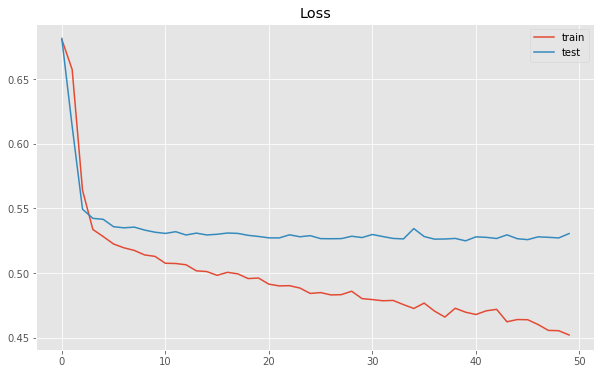

In [21]:
plt.figure(figsize=(10, 6))
plt.title('Loss')
sns.lineplot(range(len(train_loss)), train_loss, label='train')
sns.lineplot(range(len(val_loss)), val_loss, label='test')

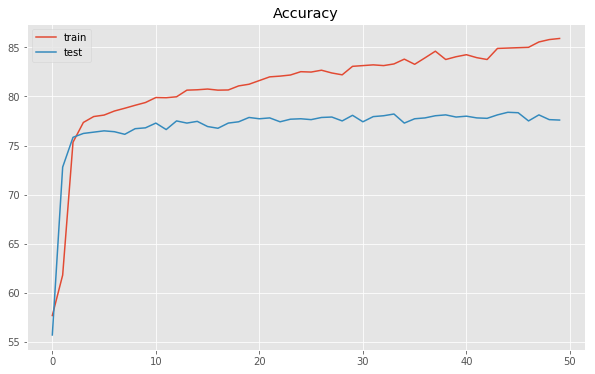

In [22]:
plt.figure(figsize=(10, 6))
plt.title('Accuracy')
sns.lineplot(range(len(train_acc)), train_acc, label='train')
sns.lineplot(range(len(val_acc)), val_acc, label='test')

## Predictions

In [23]:
model.load_state_dict(torch.load('state_dict.pth'))

<All keys matched successfully>

In [24]:
results_target = list()

with torch.no_grad():
    for batch in tqdm(test_iter):
        for text, idx in zip(batch.text[0], batch.id):
            text = text.unsqueeze(0)
            res = model(text.long())

            target = np.round(res.cpu().numpy())
            
            results_target.append(target[0][1])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [25]:
sample_submission['target'] = list(map(int, results_target))

In [27]:
sample_submission.to_csv('submission.csv', index=False)